# Support Vector Machines

Support vector machines (SVMs) are classifiers that seek to minimize classification errors. The benefit of SVMs is that they may generalize well since they find the best way to separate data instead of any random hyperplane. In cases where data is linearly separable, a hard-margin SVM finds the hyperplane farthest from any points that separate the data; if data is non-linearly separable, a soft-margin SVM allows some misclassifications.

## The algorithm

SVMs create a margin between two hyperplanes on the edge of the training classes. The goal is to maximize the distance between the margins in the hard-margin case and to keep the number of points inside the margin small in the soft-margin case. Each case can be set up as an optimization problem. To calculate the SVM, sub-gradient descent can be used on the optimization problems.

### The Pegasos algorithm
The Pegasos algorithm is a gradient descent algorithm for SVMs detailed in this paper 

[Shalev-Shwartz, S., Singer, Y., Srebro, N. et al. Pegasos: primal estimated sub-gradient solver for SVM. Math. Program. 127, 3–30 (2011).](https://doi.org/10.1007/s10107-010-0420-4)

In [11]:
import numpy as np

class SVM:
    """Support vector machine classifier."""
    def __init__(self):
        """Initialize the SVM classifier."""
        self.w = None

    def fit(self, X: np.ndarray, y: np.ndarray, lambda_val: float = 1, num_iters: int = 1000) -> None:
        """Fit the SVM classifier to the training data using gradient descent.

        Use the Pegasos algorithm to calculate the SVM.
        
        Args:
            X: Training data.
            y: Training labels.
            lambda_val: Regularization parameter.
            num_iters: Number of iterations for gradient descent.
        """
        n_samples, n_features = X.shape

        # Initialize weights and add bias term
        self.w = np.zeros(n_features + 1)
        X = np.concatenate((X, np.ones((n_samples, 1))), axis=1)

        # Gradient descent
        for _ in range(num_iters):
            # Randomly select a sample
            i = np.random.randint(n_samples)

            nu = 1 / (lambda_val * (i + 1))

            # Calculate the gradient
            if y[i] * (np.dot(self.w, X[i])) < 1:
                w = (1 - nu * lambda_val) * self.w + nu * y[i] * X[i]
            else:
                w = (1 - nu * lambda_val) * self.w

            # self.w = np.minimum(1, 1 / (np.sqrt(lambda_val) * np.linalg.norm(w))) * w

            self.w = w
        

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict labels for the test data."""
        n_samples = X.shape[0]
        X = np.concatenate((X, np.ones((n_samples, 1))), axis=1)
        return np.sign(np.dot(X, self.w))

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculate the accuracy of the predictions."""
        return np.mean(self.predict(X) == y)

## Data

SVMs classify data linearly and thus work best on linearly separable data. Non-linear kernel SVMs can classify non-linearly separable data accurately but are out of the scope of this notebook.

In [12]:
def generate_data_ls() -> tuple[np.ndarray, np.ndarray]:
    """Generate data for linearly separable case."""
    X = np.random.uniform(-1, 1, size=(100, 2))
    y = np.array([1 if x[0] + x[1] > 0 else 0 for x in X])
    return X, y

def generate_data_nls() -> tuple[np.ndarray, np.ndarray]:
    """Generate data for non-linearly separable case."""
    X = np.random.uniform(-1, 1, size=(100, 2))
    y = np.array([1 if x[0] + x[1] > 0 else 0 for x in X])
    return X, y

## Demonstration

In [13]:
from matplotlib import pyplot as plt

def plot_svm(X: np.ndarray, y: np.ndarray, model: SVM) -> None:
    """Plot the data and the decision boundary of the SVM."""
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', linestyles='dashed')
    plt.show()

### Hard-margin SVM

Linearly separable data can be classified by a hard-margin SVM, which maximizes the size of the margin between the classification boundaries of both classes.

As an optimization problem, a hard-margin SVM is:

$\textrm{minimize}_{\textbf{w},b} \quad \lVert \textbf{w} \rVert_2^2 \quad \textrm{s.t.} \quad y_i(\textbf{w}^\intercal\textbf{x}_i-b) \ge 1 \quad \forall i \in \{1,...,n\}$

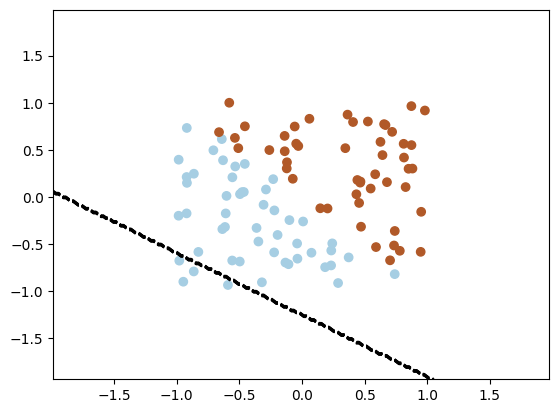

Accuracy: 0.50


In [14]:
# Generate data for linearly separable case
X, y = generate_data_ls()

# Create the model
model = SVM()

# Fit the model
model.fit(X, y)

# Plot the data and the decision boundary
plot_svm(X, y, model)

# Score the model
print(f"Accuracy: {model.score(X, y):.2f}")


### Soft-margin SVM

A soft-margin SVM can imperfectly separate non-linearly separable data. A soft-margin SVM minimizes the distance past the margin for misclassified points.

As an optimization problem, a soft-margin SVM is:

$
\textrm{minimize}_{\textbf{w},b, \zeta} \quad \lVert \textbf{w} \rVert_2^2 + C\sum_{i=1}^{N} \zeta_i \quad \textrm{s.t.} \quad y_i(\textbf{w}^\intercal\textbf{x}_i-b) \ge 1-\zeta_i, \quad \zeta_i \ge 0 \quad \forall i \in \{1,...,n\}
$

In this case, the SVM balances increasing the size of the margin vs allowing more misclassifications. The hyperparameter C places more weight on maximizing the margin distance than correctly classifying data.

C:\Users\p_t\AppData\Local\Temp\ipykernel_7976\4235603553.py:11: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, colors='k', linestyles='dashed')


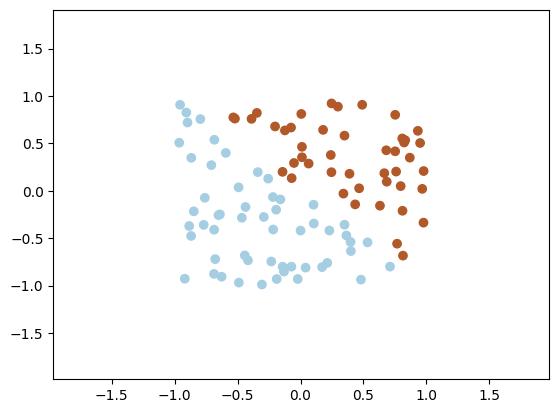

Accuracy: 0.45


In [15]:
# Generate data for non-linearly separable case
X, y = generate_data_nls()

# Create the model
model = SVM()

# Fit the model
model.fit(X, y)

# Plot the data and the decision boundary
plot_svm(X, y, model)

# Score the model
print(f"Accuracy: {model.score(X, y):.2f}")